# Introduction to 1D pulse acquisition
## Author: Vineeth Thalakottoor
## Email: vineeth.thalakottoor@ens.psl.eu or vineethfrancis.physics@gmail.com

In [1]:
# Define the source path
SourcePath = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_V1/PyOR_Combined/PyOR/Source_Doc'

# Add source path
import sys
sys.path.append(SourcePath)
import time
%matplotlib ipympl

# Import PyOR package
from PyOR_QuantumSystem import QuantumSystem as QunS
from PyOR_Hamiltonian import Hamiltonian
from PyOR_DensityMatrix import DensityMatrix
from PyOR_QuantumObject import QunObj
from PyOR_HardPulse import HardPulse
from PyOR_Basis import Basis
from PyOR_Evolution import Evolutions
from PyOR_Plotting import Plotting
import PyOR_SignalProcessing as Spro

In [2]:
# Define the spin system
Spin_list = {"A" : "H1", "B" : "H1"}
QS = QunS(Spin_list,PrintDefault=False)

# initialize the system
QS.Initialize()

### Set parameters

In [3]:
# Master Equation
QS.PropagationSpace = "Hilbert"
QS.MasterEquation = "Redfield"

# Operator Basis
QS.Basis_SpinOperators_Hilbert = "Zeeman"

# B0 Field in Tesla, Static Magnetic field (B0) along Z
QS.B0 = 9.4

# Offset Frequency in rotating frame (Hz)
QS.OFFSET["A"] = 10.0
QS.OFFSET["B"] = 50.0

# Define J coupling between Spins 
QS.JcoupleValue("A","B",5.0)

# Define initial and final Spin Temperature
QS.I_spintemp["A"] = 300.0
QS.I_spintemp["B"] = 300.0
QS.F_spintemp["A"] = 300.0
QS.F_spintemp["B"] = 300.0

# Relaxation Process
QS.Rprocess = "Phenomenological"
QS.R1 = 1
QS.R2 = 2

QS.Update()

Larmor Frequency in MHz:  [-400.22802765 -400.22806765]


### Generate Hamiltonians

In [4]:
# generate Larmor Frequencies
QS.print_Larmor = True
Ham = Hamiltonian(QS)

Larmor Frequency in MHz:  [-400.22802765 -400.22806765]


In [5]:
Hz = Ham.Zeeman_RotFrame()
Hz.Inverse2PI().matrix

Matrix([
[-30.0000000759161,                0,                 0,                0],
[                0, 20.0000008601147,                 0,                0],
[                0,                0, -20.0000008601147,                0],
[                0,                0,                 0, 30.0000000759161]])

In [6]:
# J coupling Hamiltonian
Hj = Ham.Jcoupling()
Hj.Inverse2PI().matrix

Matrix([
[1.24999997786618,                 0,                 0,                0],
[               0, -1.24999997786618,  2.49999995573235,                0],
[               0,  2.49999995573235, -1.24999997786618,                0],
[               0,                 0,                 0, 1.24999997786618]])

## Product Operator Basis (PMZ / Shift Z basis)

In [7]:
BS = Basis(QS)

sort = 'negative to positive'
Index = False
Normal = True
Basis_PMZ, coh_PMZ, dic_PMZ = BS.ProductOperators_SpinHalf_PMZ(sort,Index,Normal)

In [8]:
Basis_PMZ[0].matrix

Matrix([
[  0, 0, 0, 0],
[  0, 0, 0, 0],
[  0, 0, 0, 0],
[1.0, 0, 0, 0]])

In [9]:
print(type(Basis_PMZ))

<class 'list'>


### Product Operator Basis Zeeman

In [10]:
Basis_Zeeman, dic_Zeeman, coh_Zeeman, coh_Zeeman_array = BS.ProductOperators_Zeeman()

## Initialize density matrix

In [11]:
DM = DensityMatrix(QS,Ham)

Thermal_DensMatrix = False

if Thermal_DensMatrix:    
    # High Temperature
    HT_approx = False
    
    # Initial Density Matrix
    rho_in = DM.EqulibriumDensityMatrix(QS.Ispintemp,HT_approx)
    
    # Equlibrium Density Matrix
    rhoeq = DM.EqulibriumDensityMatrix(QS.Fspintemp,HT_approx)
else:
    rho_in = QS.Az + QS.Bz
    rhoeq = QS.Az + QS.Bz

In [12]:
DM.DensityMatrix_Components(Basis_PMZ,dic_PMZ,rho_in)

Density Matrix = 1.0 Iz1 Id2  + 1.0 Id1 Iz2 


In [13]:
DM.DensityMatrix_Components(Basis_Zeeman, dic_Zeeman,rho_in)

Density Matrix = 1.0 |1/2,1/2⟩|1/2,1/2⟩⟨1/2,1/2|⟨1/2,1/2| + -1.0 |1/2,-1/2⟩|1/2,-1/2⟩⟨1/2,-1/2|⟨1/2,-1/2|


In [14]:
# Initial Density Matrix
rho_in.matrix

Matrix([
[1.0, 0, 0,    0],
[  0, 0, 0,    0],
[  0, 0, 0,    0],
[  0, 0, 0, -1.0]])

In [15]:
# Final Density Matrix
rhoeq.matrix

Matrix([
[1.0, 0, 0,    0],
[  0, 0, 0,    0],
[  0, 0, 0,    0],
[  0, 0, 0, -1.0]])

## Hard Pulse

In [16]:
HardP = HardPulse(QS)

flip_angle1 = 90.0   # Flip angle Spin 1
flip_angle2 = 90.0 # Flip angle Spin 2

rho = HardP.Rotate_Pulse(rho_in,flip_angle1,QS.Ay)
rho = HardP.Rotate_Pulse(rho,flip_angle2,QS.By) 
rho.matrix

Matrix([
[1.38777878078145e-16,                  0.5,                  0.5, 8.32667268468867e-17],
[                 0.5, 8.32667268468867e-17, 8.32667268468867e-17,                  0.5],
[                 0.5, 8.32667268468867e-17, 8.32667268468867e-17,                  0.5],
[8.32667268468867e-17,                  0.5,                  0.5,                    0]])

In [17]:
DM.DensityMatrix_Components(Basis_PMZ,dic_PMZ,rho)

Density Matrix = 0.70711 Im1 Id2  + 0.70711 Id1 Im2  + -0.70711 Id1 Ip2  + -0.70711 Ip1 Id2 


In [18]:
DM.DensityMatrix_Components(Basis_Zeeman, dic_Zeeman,rho)

Density Matrix = 0.5 |1/2,1/2⟩|1/2,1/2⟩⟨1/2,1/2|⟨1/2,-1/2| + 0.5 |1/2,1/2⟩|1/2,1/2⟩⟨1/2,-1/2|⟨1/2,1/2| + 0.5 |1/2,1/2⟩|1/2,-1/2⟩⟨1/2,1/2|⟨1/2,1/2| + 0.5 |1/2,1/2⟩|1/2,-1/2⟩⟨1/2,-1/2|⟨1/2,-1/2| + 0.5 |1/2,-1/2⟩|1/2,1/2⟩⟨1/2,1/2|⟨1/2,1/2| + 0.5 |1/2,-1/2⟩|1/2,1/2⟩⟨1/2,-1/2|⟨1/2,-1/2| + 0.5 |1/2,-1/2⟩|1/2,-1/2⟩⟨1/2,1/2|⟨1/2,-1/2| + 0.5 |1/2,-1/2⟩|1/2,-1/2⟩⟨1/2,-1/2|⟨1/2,1/2|


## Evolution

In [19]:
QS.AcqDT = 0.0001
QS.AcqAQ = 5.0
QS.OdeMethod = 'DOP853'
QS.PropagationMethod = "ODE Solver"

EVol = Evolutions(QS,Ham)

start_time = time.time()
t, rho_t = EVol.Evolution(rho,rhoeq,Hz+Hj)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Larmor Frequency in MHz:  [-400.22802765 -400.22806765]
Total time = 2.338308811187744 seconds 


## Expectation

In [20]:
det_Mt = QS.Ap + QS.Bp
det_Z = QS.Az + QS.Bz

t, Mt = EVol.Expectation(rho_t,det_Mt)
t, Mz = EVol.Expectation(rho_t,det_Z)

## Plotting

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(<Figure size 1000x500 with 1 Axes>,
 <matplotlib.widgets.SpanSelector at 0x7f600e2c2b70>)

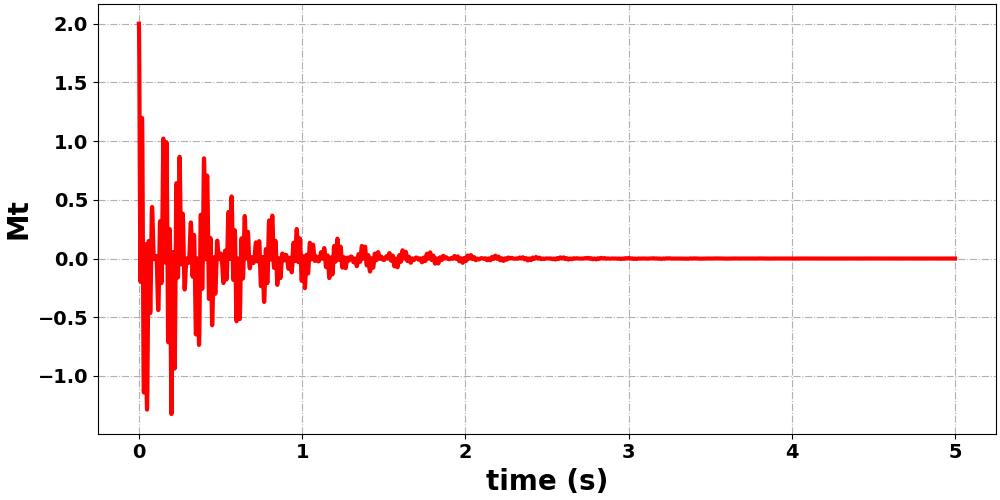

In [21]:
plot = Plotting(QS)
plot.PlotFigureSize = (10,5)
plot.PlotFontSize = 20
plot.Plotting_SpanSelector(t,Mt,"time (s)","Mt","red") 

(<Figure size 1000x500 with 1 Axes>,
 <matplotlib.widgets.SpanSelector at 0x7f600cd82090>)

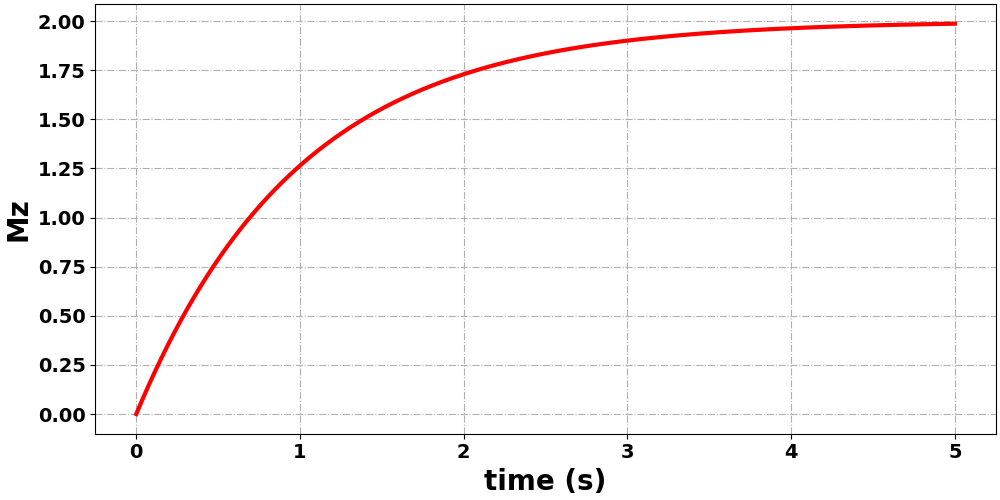

In [22]:
plot.PlotFigureSize = (10,5)
plot.PlotFontSize = 20
plot.Plotting_SpanSelector(t,Mz,"time (s)","Mz","red") 

## Fourier Transform

In [23]:
freq, spectrum = Spro.FourierTransform(Mt,QS.AcqFS,5)

(<Figure size 1000x500 with 1 Axes>,
 <matplotlib.widgets.SpanSelector at 0x7f600cdfeae0>)

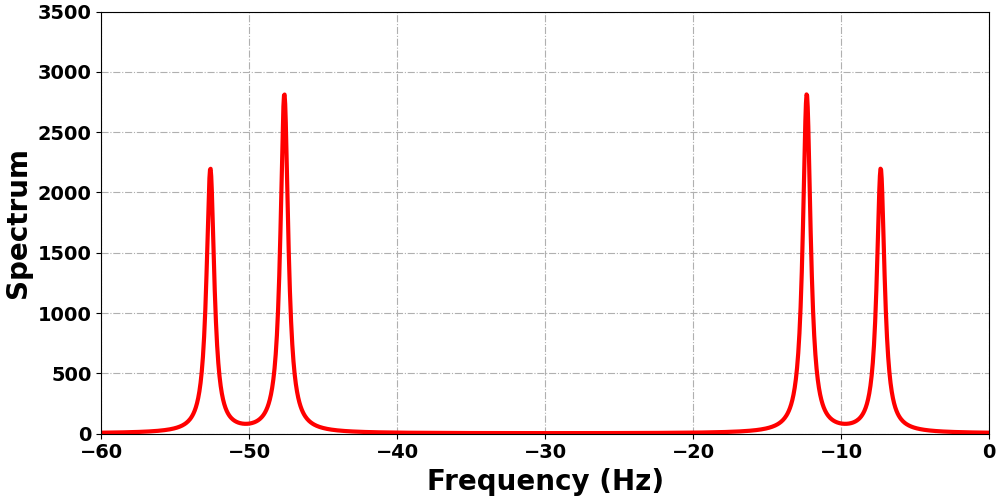

In [24]:
plot.PlotFigureSize = (10,5)
plot.PlotFontSize = 20
plot.PlotXlimt= (-60,0)
plot.PlotYlimt= (0,3500)
plot.Plotting_SpanSelector(freq,spectrum,"Frequency (Hz)","Spectrum","red")